In [99]:
import re
from tqdm import tqdm_notebook
import json
import pandas as pd

In [988]:
kuruch = pd.read_csv('../done/kuruch_revised_november_fixed.csv', encoding='utf-8')

In [239]:
kuruch.columns[:16]

Index(['transcription_backwards', 'cyrillic', 'transcription',
       'derived_cyrillic', 'derived_transcription', 'form_cyrillic',
       'form_transcription', 'часть речи', 'grammar', 'type',
       'type_alternation', 'definition', 'example_cyrillic',
       'example_transcription', 'example_definition', 'Unnamed: 16'],
      dtype='object')

# Приблизительная архитектура базы данных

1. lexems (могут быть омонимы)
 1. __id_lexem__
 2. lexem_cyrillic
 3. lexem_transcription
 
2. derivatives
 1. __id_deriv__
 2. id_lexem
 3. derived_from (id_lexem)
 
3. grammar
 1. __id_gramm__
 2. id_lexem
 3. definition
 4. form_cyrillic
 5. form_transcription
 6. pos
 7. grammar
 9. type
 8. type_alternation
 
4. examples
 1. __id_example__
 2. id_lexem
 3. id_gramm
 3. example_cyrillic
 4. example_transcription
 5. example_def
 
5. suffixes
 1. __id_suffix__
 2. form (тупо как он выглядит)
 3. meaning (можно попробовать сюда влепить штуки из столбца grammar таблички, ну или просто оставить пока пустым)
 4. vowel_alternation
 5. length
 6. palatalization
 7. voicing

### Смотрим, как там все устроено

Смотрим на повторяющиесе лексемы, нас не интересуют те, которые отличаются только примерами 

In [4]:
pd.get_option('display.max_columns')

20

In [5]:
pd.set_option('display.max_columns', 40)
kuruch[kuruch.duplicated(subset=kuruch.columns[:13], keep=False)]

,cyrillic_backwards,transcription_backwards,cyrillic,transcription,derived_cyrillic,derived_transcription,form_cyrillic,form_transcription,часть речи,grammar,type,type_alternation,definition,example_cyrillic,example_transcription,example_definition,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,...,Unnamed: 83,Unnamed: 84,Unnamed: 85,Unnamed: 86,Unnamed: 87,Unnamed: 88,Unnamed: 89,Unnamed: 90,Unnamed: 91,Unnamed: 92,Unnamed: 93,Unnamed: 94,Unnamed: 95,Unnamed: 96,Unnamed: 97,Unnamed: 98,Unnamed: 99,Unnamed: 100,Unnamed: 101,Unnamed: 102
6413,ечгаоц,ečgaoc,цоагче,coagče,ца̄гке,caag'g'e,NaN,NaN,Verb,"постоянно;иногда, бывало",III,NaN,"надевать, примерять что (постоянно;иногда, быв...",цоагэч о̄дт вуэсскэдт кабперь,coageč oodt vuesskedt kabp'er',примерь новую пыжиковую шапку,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6414,ечгаоц,ečgaoc,цоагче,coagče,ца̄гке,caag'g'e,NaN,NaN,Verb,"постоянно;иногда, бывало",III,NaN,"надевать, примерять что (постоянно;иногда, быв...",NaN,"to ž'e, čto coagne",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
pd.set_option('display.max_columns', 20)

Сейчас совместим ручками первый дубликат.

In [209]:
with open('../done/kuruch_revised_november_fixed.csv', encoding='utf-8') as f:
    kuruch_row = f.read()

kuruch_row = kuruch_row.replace("еъкгаоц,ejggaoc,цоагкъе,coaggje,ца̄гке,caag'g'e,,,Verb,страд.,III,,страд. к ца̄гке,,strad. k caagk'e,,пугк оассэ цоагкъенҍ вӯссе,pugk oasse coagkjen' vuus's'e,вся одежда засунута в кису (в национальную сумку),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,\n",
                   "")
kuruch_row = kuruch_row.replace("еъкгаоц,ejggaoc,цоагкъе,coaggje,ца̄гке,caag'g'e,,,Verb,страд.,III,,страд. к ца̄гке,,strad. k caagk'e,,одьяла оллька цоагкэй одьяла э̄л,od'jala ol'l'ka coagkej od'jala eel,пододеяльник надет на одеяло,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",
                   "еъкгаоц,ejggaoc,цоагкъе,coaggje,ца̄гке,caag'g'e,,,Verb,страд.,III,,страд. к ца̄гке,,strad. k caagk'e,,одьяла оллька цоагкэй одьяла э̄л,od'jala ol'l'ka coagkej od'jala eel,пододеяльник надет на одеяло,пугк оассэ цоагкъенҍ вӯссе,pugk oasse coagkjen' vuus's'e,вся одежда засунута в кису (в национальную сумку),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,")


with open('../done/kuruch_revised_november_fixed.csv', 'w', encoding='utf-8') as f:
    f.write(kuruch_row)

In [210]:
kuruch = pd.read_csv('../done/kuruch_revised_november_fixed.csv', encoding='utf-8')

Удалим второй дубликат.

In [989]:
kuruch[kuruch.duplicated(subset=kuruch.columns[:13], keep=False)]

,cyrillic_backwards,transcription_backwards,cyrillic,transcription,derived_cyrillic,derived_transcription,form_cyrillic,form_transcription,часть речи,grammar,...,Unnamed: 93,Unnamed: 94,Unnamed: 95,Unnamed: 96,Unnamed: 97,Unnamed: 98,Unnamed: 99,Unnamed: 100,Unnamed: 101,Unnamed: 102
6413,ечгаоц,ečgaoc,цоагче,coagče,ца̄гке,caag'g'e,NaN,NaN,Verb,"постоянно;иногда, бывало",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6414,ечгаоц,ečgaoc,цоагче,coagče,ца̄гке,caag'g'e,NaN,NaN,Verb,"постоянно;иногда, бывало",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [990]:
kuruch.drop_duplicates(subset=kuruch.columns[:13], inplace=True)

Теперь будем работать только со "статьями" лексем, без примеров.

In [9]:
kuruch_short = kuruch.drop(columns=kuruch.columns[13:])

In [10]:
kuruch_short.describe()

,cyrillic_backwards,transcription_backwards,cyrillic,transcription,derived_cyrillic,derived_transcription,form_cyrillic,form_transcription,часть речи,grammar,type,type_alternation,definition
count,7397,7397,7397,7397,7397,7397,1137,1137,7394,3659,6309,1586,7397
unique,7349,7338,7348,7338,1865,1866,1120,1120,20,57,5,10,6689
top,энз̄ок,enneem,каһце,oaz,э̄ххт,eexxt,ма̄д,laaf'k,Verb,"постоянно;иногда, бывало",III,1*,"начать дышать тяжело (высунув язык, напр. посл..."
freq,2,2,2,2,26,26,2,2,4924,728,2871,582,4


Посмотрим какие есть повторяющиеся и неповторяющиесе категории

In [11]:
kuruch_short.groupby(['cyrillic']).transcription.nunique().loc[lambda x: x > 1]

cyrillic
ко̄ммтнэ    2
Name: transcription, dtype: int64

In [12]:
kuruch_short[kuruch_short.cyrillic == 'ко̄ммтнэ']

,cyrillic_backwards,transcription_backwards,cyrillic,transcription,derived_cyrillic,derived_transcription,form_cyrillic,form_transcription,часть речи,grammar,type,type_alternation,definition
1721,энтммаок,entmmaok,ко̄ммтнэ,koammtne,ко̄ммьтэсь,koom'm'tes',NaN,NaN,Verb,NaN,NaN,NaN,"то же, что ко̄ммтнэ"
1722,энтмм̄ок,entmmook,ко̄ммтнэ,koommtne,ко̄ммьтэсь,koom'm'tes',NaN,NaN,Verb,стать,III,NaN,"стать более широким, расшириться;разноситься (..."


In [13]:
kuruch_short.groupby(['transcription']).cyrillic.nunique().loc[lambda x: x > 1]

transcription
meenne     2
poonne     2
suanne     2
sɨnne      2
tuunne     2
veenne     2
zvoonne    2
čiinne     2
činne      2
čoonne     2
ž'eenne    2
Name: cyrillic, dtype: int64

In [14]:
kuruch_short[kuruch_short.transcription == 'poonne']

,cyrillic_backwards,transcription_backwards,cyrillic,transcription,derived_cyrillic,derived_transcription,form_cyrillic,form_transcription,часть речи,grammar,type,type_alternation,definition
4249,энн̄оп,ennoop,по̄ннэ,poonne,по̄ннэ,poonne,NaN,NaN,Verb,NaN,I,1,сучить (ножками);пинать кого-что
4252,энън̄оп,ennoop,по̄нънэ,poonne,поаннэ,poanne,NaN,NaN,Verb,"постоянно;иногда, бывало",III,NaN,"прясть что (постоянно;иногда, бывало)"


Это куруч так отделяет суффикс когда он сливается

In [15]:
kuruch_short.groupby(['transcription']).form_transcription.nunique().loc[lambda x: x > 1]

transcription
oaz    2
Name: form_transcription, dtype: int64

In [16]:
kuruch_short[kuruch_short.transcription == 'oaz']

,cyrillic_backwards,transcription_backwards,cyrillic,transcription,derived_cyrillic,derived_transcription,form_cyrillic,form_transcription,часть речи,grammar,type,type_alternation,definition
3639,зао,zao,оаз,oaz,оаз,oaz,оадзэ,oaʒe,Noun,NaN,IV,NaN,паук
3640,зао,zao,оаз,oaz,оаз,oaz,оассэ,oasse,Noun,NaN,IV,NaN,"одежда, наряд, туалет"


Это просто разные слова, видимо

In [17]:
kuruch_short.groupby(['transcription']).definition.nunique().loc[lambda x: x > 1].shape

(58,)

In [18]:
kuruch_short[kuruch_short.transcription == "ɲuuxxčem'"]

,cyrillic_backwards,transcription_backwards,cyrillic,transcription,derived_cyrillic,derived_transcription,form_cyrillic,form_transcription,часть речи,grammar,type,type_alternation,definition
3541,ьмечхх̄юн,'mečxxuuɲ,ню̄ххчемь,ɲuuxxčem',ню̄ххчемь,ɲuuxxčem',NaN,NaN,Noun,общее число,V,NaN,язык
3542,ьмечхх̄юн,'mečxxuuɲ,ню̄ххчемь,ɲuuxxčem',ню̄ххчемь,ɲuuxxčem',NaN,NaN,Noun,общее число,V,NaN,"язычок (обуви, колокола и т. п.)"


In [19]:
kuruch_short.groupby(['transcription']).derived_transcription.nunique().loc[lambda x: x > 1]

transcription
eesste         2
k'iissje       2
kooddjuvve     2
koodne         2
koozne         2
koozse         2
kɨpptje        2
lɨggse         2
moaddje        2
paaš'txe       2
poakne         2
poonne         2
roaddje        2
roadne         2
sajxe          2
vaajjmluvve    2
čeelkxe        2
Name: derived_transcription, dtype: int64

In [20]:
kuruch_short[kuruch_short.transcription == "eesste"]

,cyrillic_backwards,transcription_backwards,cyrillic,transcription,derived_cyrillic,derived_transcription,form_cyrillic,form_transcription,часть речи,grammar,type,type_alternation,definition
7227,этсс̄э,etssee,э̄сстэ,eesste,асст,asst,NaN,NaN,Verb,NaN,II,1,иметь свободное время
7228,этсс̄э,etssee,э̄сстэ,eesste,э̄сстэ,eesste,NaN,NaN,Verb,сделать,II,1,"догнать, настичь кого-что;застать, захватить к..."


Видимо, есть формы которые похожи друг на друга но происходят от разных корней.

In [148]:
kuruch_short.groupby(['transcription']).grammar.nunique().loc[lambda x: x > 1]

transcription
k'iillluvne    2
koodne         2
koozne         2
koozse         2
kuuntče        2
roadne         2
vɨrne          2
Name: grammar, dtype: int64

In [152]:
kuruch_short[kuruch_short.transcription == "vɨrne"]

,cyrillic_backwards,transcription_backwards,cyrillic,transcription,derived_cyrillic,derived_transcription,form_cyrillic,form_transcription,часть речи,grammar,type,type_alternation,definition
874,энрыв,enrɨv,вырнэ,vɨrne,выррэ,vɨrre,NaN,NaN,Verb,"постоянно; иногда, бывало",III,NaN,"проваливаться (куда-л. - постоянно;иногда, быв..."
875,энрыв,enrɨv,вырнэ,vɨrne,выррэ,vɨrre,NaN,NaN,Verb,"постоянно;иногда, бывало",III,NaN,"налетать (постоянно;иногда, бывало);выпадать (..."


In [154]:
kuruch_short.groupby(['transcription']).type_alternation.nunique().loc[lambda x: x > 1]

transcription
l'aašške    2
Name: type_alternation, dtype: int64

In [155]:
kuruch_short[kuruch_short.transcription == "l'aašške"]

,cyrillic_backwards,transcription_backwards,cyrillic,transcription,derived_cyrillic,derived_transcription,form_cyrillic,form_transcription,часть речи,grammar,type,type_alternation,definition
2793,экшш̄ял,ekššaa'l,ля̄шшкэ,l'aašške,ля̄шшкэ,l'aašške,NaN,NaN,Verb,NaN,II,2,"ловить арканом, арканить (оленя)"
2794,экшш̄ял,ekššaa'l,ля̄шшкэ,l'aašške,ля̄шшкэ,l'aašške,NaN,NaN,Verb,NaN,II,3,выплёскивать что;выплёскиваться (откуда-л.);пл...


Видимо, больше "особых" примеров нет. Но надо поменять структуру лексем, потому что есть омонимы.

### Категориальные параметры

In [331]:
kuruch['часть речи'].unique() # можно оставить для читаемости

array(['Noun', 'Verb', 'Mor', 'Conj', 'Inter', 'AdjPred', 'Adv', 'Adj',
       'Prep', 'Part', 'Num', 'Pred', 'PostP', 'AdvLike', 'Conj/Part',
       'Adv/Conj/Part', nan, 'Pro', 'AdjComp', 'AdvPred', 'Phr'],
      dtype=object)

In [332]:
kuruch['grammar'].unique() # слишком много, можно оставить

array([nan, 'постоянно;иногда, бывало', 'сказ.', 'Trop', 'общее число',
       'начать', 'постоянно', 'иногда, бывало',
       'немного - постоянно;иногда, бывало', 'недолго, немного',
       'быстро, немного', 'стать', 'страд.', 'быстро', 'сделать',
       'понуд.', 'однокр.', 'безл.', 'обеспечить', 'быстро, недолго',
       'быстро, недолго, немного', 'появиться',
       'постоянно; иногда, бывало', 'лишить', 'лишиться', 'немного',
       'в разных направлениях, постоянно; иногда, бывало', 'недолго',
       'заставить', 'некоторое время, немного', 'побуждать',
       'быстро, ненадолго', 'некоторое время', 'быстро, вдруг',
       'ненадолго', 'друг друга', 'немного, однокр.', 'вдруг',
       'медленно, постепенно', 'немного, постоянно; иногда, бывало',
       'слегка', 'в настоящий момент', 'недолго, некоторое время',
       'бывало, иногда', 'быстро, некоторое время, немного, совсем',
       'в данный момент', 'некоторое время, слегка',
       'безл., немного, постоянно; иногда, быв

In [333]:
kuruch['type'].unique() # надо преобразовать в числа

array(['II', 'I', nan, 'III', 'V', 'IV'], dtype=object)

In [334]:
kuruch['type'].replace({'II':2, 'I':1, 'III':3, 'V':5, 'IV':4}, inplace=True)

In [335]:
kuruch['type_alternation'].unique() # можно не преобразововать, а то станет сложнее, но почистить можно

array(['3', '2', nan, '1*', '4', '4*', '1 *', 'III', '1', '5', '1.'],
      dtype=object)

In [336]:
kuruch_short[kuruch_short.type_alternation == "III"]

,cyrillic_backwards,transcription_backwards,cyrillic,transcription,derived_cyrillic,derived_transcription,form_cyrillic,form_transcription,часть речи,grammar,type,type_alternation,definition
216,ькһ̄а,'khaa,а̄һкь,aahk',а̄һкь,aahk',а̄кь,aak',Noun,NaN,I,III,"женщина (замужняя), баба прост."


In [337]:
kuruch.type_alternation.replace('1 *','1*', inplace=True)
kuruch.type_alternation.replace('1.','1', inplace=True)
kuruch.type_alternation.replace('III','3', inplace=True)

In [338]:
kuruch['type_alternation'].unique()

array(['3', '2', nan, '1*', '4', '4*', '1', '5'], dtype=object)

### Достаем корни

In [ ]:
re.sub(r'([A-Z])',lambda x: x.group(1).lower() + chr(805), roots_text)

In [351]:
roots = pd.read_csv('../done/roots.csv', encoding='utf-16', header=0)

In [999]:
roots.head(2)

,Derived,Derivator,Meaning,Original root,Word root,Remainder,Alternations,Length,Palatalization,Voicing,Smth strange,id_suffix_form
0,aav'v'l,aav'v'l,аввель (перекладина с крючьями для подвешивани...,ROOT WORD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,taall,taall,медведь м,ROOT WORD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1001]:
roots['Original root'].replace({'ROOT WORD':'root word'}, inplace=True)

In [1007]:
for column in ['Derived', 'Derivator', 'Original root', 'Word root', 'Remainder', 'Alternations']:
    roots[column] = roots[column].str.replace(r'([RNML])', lambda x: x.group(1).lower() + chr(805))

In [1008]:
kuruch['root'] = roots['Word root']

Достаем суффиксы

In [1009]:
roots.columns

Index(['Derived', 'Derivator', 'Meaning', 'Original root', 'Word root',
       'Remainder', 'Alternations', 'Length', 'Palatalization', 'Voicing',
       'Smth strange', 'id_suffix_form'],
      dtype='object')

In [1010]:
roots.loc[roots['Original root'] == 'WARNING! Dictionary error', 'Length'] = np.nan

In [1011]:
roots.Palatalization.replace({'- // -':'--', '- // +':'-+', '+ // -':'+-', '+ // +':'++'},inplace=True)
roots.Length.replace({'- // -':'--', '- // +':'-+', '+ // -':'+-', '+ // +':'++'},inplace=True)
roots.Voicing.replace({'- // +':'-+', '+ // -':'+-', 'Same':'same'},inplace=True)

In [1012]:
roots_deriv = roots.loc[roots['Original root'] != 'ROOT WORD'.lower()]

In [1013]:
# надо заполнить чтобы это было в обобщающей таблице
roots_deriv[['Length','Voicing','Palatalization']] = roots_deriv[['Length','Voicing','Palatalization']].fillna('None')

C:\Users\Mi\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [1014]:
roots_deriv[['Length','Voicing','Palatalization']].head()

,Length,Voicing,Palatalization
2,++,same,--
3,None,None,None
4,--,same,-+
5,None,None,None
6,None,same,None


In [1015]:
roots_deriv.groupby(['Remainder','Length','Palatalization']).Voicing.value_counts().to_csv('../done/suffixes_forms.csv')

In [1016]:
suffixes_forms = pd.read_csv('../done/suffixes_forms.csv')

In [1017]:
suffixes_forms = suffixes_forms.reset_index().drop(columns=['Voicing.1'])

Вычесляем индексы(id)

In [841]:
def index_suffixes_forms(row):
    index = suffixes_forms.loc[(row['Remainder'] == suffixes_forms['Remainder']) &
                              (row['Length'] == suffixes_forms['Length']) &
                              (row['Palatalization'] == suffixes_forms['Palatalization']) &
                              (row['Voicing'] == suffixes_forms['Voicing'])]['index']
    if index.values.shape[0] != 0:
        return index.values[0]

In [1018]:
roots_deriv['id_suffix_form'] = roots_deriv.apply(index_suffixes_forms, axis=1)

C:\Users\Mi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [1019]:
roots_deriv['id_suffix_form'].head(10)

2     625.0
3     767.0
4       NaN
5       NaN
6     128.0
7       NaN
8      29.0
9     763.0
12     40.0
13    739.0
Name: id_suffix_form, dtype: float64

In [1020]:
suffixes = suffixes_forms.Remainder.unique()

In [1021]:
def index_suffixes(x):
    if not pd.isnull(x):
        return np.where(suffixes==x)[0][0]
    
roots_deriv['id_suffix'] = roots_deriv.Remainder.apply(index_suffixes)

C:\Users\Mi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [1023]:
kuruch['suffix'] = roots.Remainder

In [1024]:
kuruch['id_suffix'] = kuruch.suffix.apply(index_suffixes)

In [1025]:
suffixes_forms['id_suffix'] = suffixes_forms.Remainder.apply(index_suffixes)

Посмотрим на grammar

In [1026]:
kuruch.groupby('suffix').grammar.nunique()[kuruch.groupby('suffix').grammar.nunique() > 1]

suffix
a          3
aht'       9
as         2
as's't    10
asxuvv     2
          ..
čedd       4
š          3
šaht'      2
šennt      2
šuvv       2
Name: grammar, Length: 76, dtype: int64

In [541]:
import re

In [1027]:
def combine_grammar(suffix):
    meanings = set()
    for m in kuruch.grammar[kuruch.suffix == suffix].unique():
        if not pd.isnull(m):
            meanings.update(re.split(r' ?[,;] ?', m))
    return ', '.join(meanings)

In [1028]:
suffix_meanings = []
for suffix in suffixes:
    suffix_meanings.append(combine_grammar(suffix))

In [1029]:
suffix_meanings[167]

'постоянно, начать, бывало, недолго, однокр., ненадолго, иногда, некоторое время, сделать, совсем, немного, вдруг, безл., быстро'

Alternations

In [1030]:
alts = roots.Alternations.dropna().apply(lambda x: x.split(';')).explode().apply(lambda x: x.split(' // '))

alts = [(i,l) for i, l in list(alts.items()) if len(l) > 1]

In [1031]:
vowels = 'aɨueio'
alts_tri = []
for i, [alt1,alt2] in alts:
    v = False
    alt1 = alt1.replace('-','').strip()
    alt2 = alt2.replace('-','').strip()
    if alt1[0] in vowels:
        v = True
    alts_tri.append((i,alt1,alt2,v))

In [1032]:
len(alts_tri)

4413

# Делаем базу данных

1. lexems (могут быть омонимы)
 1. __id_lexem__
 2. lexem_cyrillic
 3. lexem_transcription
 4. definition
 5. form_cyrillic
 6. form_transcription
 7. pos
 8. cn?
 8. grammar
 9. type
 10. type_alternation
 
2. derivatives
 1. __id_deriv__
 2. id_lexem
 3. derived_from (id_lexem)
 4. root
 5. id_suffix_form
 
3. alternations
 1. __id_alt__
 2. id_deriv
 3. id_suffix_form
 3. from
 4. to
 5. vowel?
 
4. examples
 1. __id_example__
 2. id_lexem
 3. id_gramm
 3. example_cyrillic
 4. example_transcription
 5. example_def
 
5. suffixes
 1. __id_suffix__
 2. form (тупо как он выглядит)
 3. grammar

6. suffixes_forms
 1. __id_suffix_form__
 2. id_suffix
 5. length
 6. palatalization
 7. voicing

In [29]:
!pip3 install mysql-connector-python

You should consider upgrading via the 'c:\users\mi\appdata\local\programs\python\python37-32\python.exe -m pip install --upgrade pip' command.


In [30]:
import mysql.connector

Создаем базу данных

In [1034]:
with open('../config.txt', encoding='utf-8') as f:
    PASSWORD = f.read()

In [1035]:
con = mysql.connector.connect(host='127.0.0.1', port=3306, user='root', password=PASSWORD)

In [1036]:
cur=con.cursor(dictionary=True)

In [34]:
cur.execute("CREATE DATABASE kuruch /*!40100 DEFAULT CHARACTER SET utf8mb4 COLLATE utf8mb4_0900_ai_ci */ /*!80016 DEFAULT ENCRYPTION='N' */;")

Подключаемся к созданной базе данных

In [1037]:
con = mysql.connector.connect(host='127.0.0.1', port=3306, database='kuruch', user='root', password=PASSWORD)
cur=con.cursor(dictionary=True)

Создадим таблицы вручную

Заливаем данные из таблицы

In [52]:
kuruch.reset_index(inplace=True)

In [176]:
kuruch.columns[:14]

Index(['cyrillic_backwards', 'transcription_backwards', 'cyrillic',
       'transcription', 'derived_cyrillic', 'derived_transcription',
       'form_cyrillic', 'form_transcription', 'часть речи', 'grammar', 'type',
       'type_alternation', 'definition', 'example_cyrillic'],
      dtype='object')

In [1038]:
kuruch.shape

(7397, 106)

### lexems (могут быть омонимы)
 1. __id_lexem__
 2. lexem_cyrillic
 3. lexem_transcription
 4. definition
 5. form_cyrillic
 6. form_transcription
 7. pos
 8. common number?
 9. grammar
 9. type
 10. type_alternation

Из grammar надо достать отдельно общее число и остальные признаки

In [348]:
kuruch['cn'] = kuruch.grammar.apply(lambda x: x == 'общее число')
kuruch['grammar'] = kuruch.grammar.where(lambda x: x != 'общее число')

In [528]:
req = "DROP table kuruch.lexemes;"
cur.execute(req)

req = """CREATE TABLE `lexemes` (
  `id_lexem` int(11) NOT NULL AUTO_INCREMENT,
  `cyrillic` varchar(32) NOT NULL,
  `transcription` varchar(32) NOT NULL,
  `definition` varchar(1024) DEFAULT NULL,
  `form_cyrillic` varchar(32) DEFAULT NULL,
  `form_transcription` varchar(32) DEFAULT NULL,
  `pos` varchar(16) DEFAULT NULL,
  `cn` tinyint(1) DEFAULT NULL,
  `grammar` varchar(64) DEFAULT NULL,
  `type` int(11) DEFAULT NULL,
  `type_alternation` varchar(8) DEFAULT NULL,
  PRIMARY KEY (`id_lexem`),
  UNIQUE KEY `idgrammar_UNIQUE` (`id_lexem`)
) ENGINE=InnoDB AUTO_INCREMENT=7398 DEFAULT CHARSET=utf8mb4 COLLATE=utf8mb4_0900_ai_ci;
"""
cur.execute(req)

req = "ALTER TABLE kuruch.lexemes AUTO_INCREMENT = 1;"
cur.execute(req)
con.commit()

In [522]:
lexemes = ['("{}","{}","{}","{}","{}","{}",{},"{}","{}","{}")'.format(*x).replace('"nan"','NULL') for x in kuruch[['cyrillic','transcription','definition','form_cyrillic','form_transcription','часть речи','cn','grammar','type','type_alternation']].values]

In [525]:
con.rollback()

In [529]:
%%time
for i in range(8):
    req="INSERT INTO lexemes (cyrillic, transcription, definition, form_cyrillic, form_transcription, pos, cn, grammar, type, type_alternation) VALUES " + ",".join(lexemes[i*1000:(i+1)*1000])
    cur.execute(req)
con.commit()

Wall time: 573 ms


 ### derivatives
 1. __id_deriv__
 2. id_lexem
 3. derived_from (id_lexem)
 4. root
 5. id_suffix_form

In [1039]:
kuruch.derived_cyrillic.where(kuruch.derived_cyrillic != kuruch.cyrillic, inplace=True)

In [1041]:
missing = []
multiple = []
def find_id_deriv(derived_cyrillic):
    if derived_cyrillic is not np.nan:
        if derived_cyrillic not in kuruch.cyrillic.values:
            if derived_cyrillic not in missing:
                missing.append(derived_cyrillic)
        else:
            indexes = kuruch[kuruch.cyrillic == derived_cyrillic].index.values
            if indexes.shape[0] > 1:
                if derived_cyrillic not in multiple:
                    multiple.append(derived_cyrillic)
            return indexes[0]
    
id_deriv = kuruch.derived_cyrillic.apply(find_id_deriv)

In [1042]:
missing

['дэдт', 'дэн', 'ка̄ннҍц', 'ла̄ввь (ла̄вь)', 'хэ̄ӆӆпэ', 'ца̄гке']

In [1043]:
multiple

['а̄ввь',
 'бакалл',
 'выррэ',
 'ӣнн',
 'каһце',
 'кэ̄сск',
 'кӣлл',
 'кӯннҍтэ',
 'ла̄ффьк',
 'ля̄шшкэ',
 'лыввэ',
 'лыгксэ',
 'ма̄дт',
 'мырр',
 'ню̄ххчемь',
 'оаз',
 'па̄шьтхэ',
 'рӯһц',
 'суннҍт',
 'цыӈӈьк',
 'э̄сстэ']

In [1044]:
req = "DROP table kuruch.derivatives;"
cur.execute(req)

req = """CREATE TABLE `derivatives` (
  `id_deriv` int(11) NOT NULL AUTO_INCREMENT,
  `id_lexem` int(11) DEFAULT NULL,
  `derived_from` int(11) DEFAULT NULL,
  `root` varchar(45) DEFAULT NULL,
  `id_suffix_form` int(11) DEFAULT NULL,
  PRIMARY KEY (`id_deriv`)
) ENGINE=InnoDB AUTO_INCREMENT=5520 DEFAULT CHARSET=utf8mb4 COLLATE=utf8mb4_0900_ai_ci;

"""
cur.execute(req)

req = "ALTER TABLE kuruch.derivatives AUTO_INCREMENT = 1;"
cur.execute(req)
con.commit()

In [643]:
kuruch.shape[0], roots_deriv.shape[0], roots.shape[0], id_deriv.shape[0]

(7397, 5514, 7398, 7397)

In [1046]:
roots.loc[roots['Original root'] != 'ROOT WORD'.lower(),'id_suffix_form'] = roots_deriv.id_suffix_form

In [1047]:
derivs = ['("{}","{}","{}","{}")'.format(i+1,x+1,roots['Word root'][i],roots.id_suffix_form[i]+1).replace('"nan"','NULL') for i, x in id_deriv.dropna().items() if (i != x)]

In [1048]:
%%time

for i in range(len(derivs)//1000+1):
    req="INSERT INTO derivatives (id_lexem, derived_from, root, id_suffix_form) VALUES " + ",".join(derivs[i*1000:(i+1)*1000])
    cur.execute(req)
con.commit()

Wall time: 126 ms


In [657]:
con.rollback()

### examples
 1. __id_example__
 2. id_lexem
 3. example_cyrillic
 4. example_transcription
 5. example_def

In [136]:
kuruch_examples = kuruch[kuruch.columns[14:]]

In [203]:
examples = []
errors = []
shifted = []
for i, x in enumerate(kuruch_examples.values):
    try:
        for example in x[~pd.isnull(x)].reshape(-1,3):
            examples.append('({},"{}","{}","{}")'.format(*[i+1] + list(example)))
    except ValueError:
        try:
            for example in x[3:][~pd.isnull(x[3:])].reshape(-1,3):
                examples.append('({},"{}","{}","{}")'.format(*[i+1] + list(example)))
            shifted.append((i,x[:3]))
        except:
            errors.append(i)

In [199]:
len(examples)

10372

In [200]:
len(errors)

26

In [201]:
len(shifted)

792

In [194]:
kuruch.iloc[errors].to_csv('../done/examples_errors.csv')

In [196]:
kuruch.iloc[[x[0] for x in shifted]].to_csv('../done/examples_shifted.csv')

In [212]:
%%time
for i in range(len(examples)//1000+1):
    req="INSERT INTO examples (id_lexem, example_cyrillic, example_transcription, example_def) VALUES " + ",".join(examples[i*1000:(i+1)*1000])
    cur.execute(req)
con.commit()

Wall time: 220 ms


 ### alternations
 1. __id_alt__
 2. id_deriv
 3. id_suffix_form
 3. from
 4. to
 5. vowel?

In [1049]:
req = "DROP table kuruch.alternations;"
cur.execute(req)

req = """CREATE TABLE `alternations` (
  `id_alt` int(11) NOT NULL AUTO_INCREMENT,
  `id_deriv` int(11) DEFAULT NULL,
  `id_suffix_form` int(11) DEFAULT NULL,
  `from` varchar(32) DEFAULT NULL,
  `to` varchar(32) DEFAULT NULL,
  `isVowel` tinyint(1) DEFAULT NULL,
  PRIMARY KEY (`id_alt`)
) ENGINE=InnoDB AUTO_INCREMENT=5520 DEFAULT CHARSET=utf8mb4 COLLATE=utf8mb4_0900_ai_ci;

"""
cur.execute(req)

req = "ALTER TABLE kuruch.alternations AUTO_INCREMENT = 1;"
cur.execute(req)
con.commit()

In [1050]:
derivs_df = pd.DataFrame([x.replace("NULL",'"NULL"')[2:-2].split('","') for x in derivs], columns=['id_lexeme','deriv_from','root','id_suffix_form'])

In [1051]:
derivs_df.id_lexeme = derivs_df.id_lexeme.astype(np.int64)

In [1052]:
derivs_df.reset_index(inplace=True)

In [1053]:
alts_df = pd.DataFrame(alts_tri, columns=['id_lexeme','from','to','isVowel'])

In [1054]:
alts_df = alts_df.merge(derivs_df, on='id_lexeme').loc[:,['index','id_suffix_form', 'from','to','isVowel']]

In [1055]:
alternations = ['("{}","{}","{}","{}",{})'.format(*x).replace('"nan"','NULL') for x in alts_df.values]

In [1056]:
%%time

for i in range(len(alternations)//1000+1):
    req="INSERT INTO alternations (id_deriv, id_suffix_form, `from`, `to`, isVowel) VALUES " + ",".join(alternations[i*1000:(i+1)*1000])
    cur.execute(req.replace('"NULL"','NULL'))
con.commit()

Wall time: 92.8 ms


### suffixes
 1. __id_suffix__
 2. form (тупо как он выглядит)
 3. grammar

In [1057]:
req = "DROP table kuruch.suffixes;"
cur.execute(req)

req = """CREATE TABLE `suffixes` (
  `id_suffix` int(11) NOT NULL AUTO_INCREMENT,
  `form` varchar(45) DEFAULT NULL,
  `meaning` varchar(256) DEFAULT NULL,
  PRIMARY KEY (`id_suffix`),
  UNIQUE KEY `id_suffix_UNIQUE` (`id_suffix`)
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4 COLLATE=utf8mb4_0900_ai_ci;
"""
cur.execute(req)

req = "ALTER TABLE kuruch.suffixes AUTO_INCREMENT = 1;"
cur.execute(req)
con.commit()

In [1058]:
suffixes_values = ['("{}","{}")'.format(*x).replace('""','NULL') for x in zip(suffixes, suffix_meanings)]

In [1059]:
suffix_meanings[283]

'постоянно, начать, страд., обеспечить, бывало, однокр., некоторое время, заставить, иногда, сделать, безл., немного, появиться, понуд., быстро'

In [1060]:
len(suffix_meanings[167].encode('utf-8'))

225

In [1061]:
%%time

for i in range(len(suffixes_values)//1000+1):
    req="INSERT INTO suffixes (form, meaning) VALUES " + ",".join(suffixes_values[i*1000:(i+1)*1000])
    cur.execute(req)
con.commit()

Wall time: 16 ms


### suffixes_forms
 1. __id_suffix_form__
 2. id_suffix
 5. length
 6. palatalization
 7. voicing

In [1062]:
req = "DROP table kuruch.suffixes_forms;"
cur.execute(req)

req = """CREATE TABLE `suffixes_forms` (
  `id_suffix_form` int(11) NOT NULL AUTO_INCREMENT,
  `id_suffix` int(11) DEFAULT NULL,
  `length` varchar(45) DEFAULT NULL,
  `palatalization` varchar(45) DEFAULT NULL,
  `voicing` varchar(45) DEFAULT NULL,
  PRIMARY KEY (`id_suffix_form`),
  UNIQUE KEY `id_suffix_UNIQUE` (`id_suffix_form`)
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4 COLLATE=utf8mb4_0900_ai_ci;
"""
cur.execute(req)

req = "ALTER TABLE kuruch.suffixes_forms AUTO_INCREMENT = 1;"
cur.execute(req)
con.commit()

In [1063]:
suffixes_forms['id_suffix'] = suffixes_forms['id_suffix'] + 1

In [1064]:
suffixes_forms_values = ['("{}","{}","{}","{}")'.format(*x).replace('"nan"','NULL') for x in suffixes_forms[['id_suffix','Length','Palatalization','Voicing']].values]

In [1065]:
suffixes_forms_values[:5]

['("1","++","++","same")',
 '("2","++","++","same")',
 '("3","None","None","None")',
 '("4","None","None","None")',
 '("5","None","None","None")']

In [1066]:
suffixes_forms.Voicing.unique()

array(['same', 'None', '-+', '+-'], dtype=object)

In [1067]:
%%time

for i in range(len(suffixes_forms_values)//1000+1):
    req="INSERT INTO suffixes_forms (id_suffix, length, palatalization, voicing) VALUES " + ",".join(suffixes_forms_values[i*1000:(i+1)*1000])
    cur.execute(req.replace('None','NULL'))
con.commit()

Wall time: 32.9 ms


In [1068]:
roots.Remainder.value_counts().to_csv('../done/suffixes_counts.csv')

## Смотрим как возвращаются результаты

In [890]:
cur.execute("""
SELECT DISTINCT `from` FROM kuruch.alternations;
""")
res = cur.fetchall()

In [895]:
from_sounds = [r['from'] for r in res if r['from'] is not None]
sounds = sorted(sounds)

In [20]:
show = [('lexemes.cyrillic', 'cyrillic'), ('lexemes.transcription', 'transcription'), ('derivatives.derived_from', 'derived_from'), ('derivatives.root', 'root'), ('lexemes.definition', 'definition'), ('lexemes.form_cyrillic', 'form_cyrillic'), ('lexemes.form_transcription', 'form_transcription'), ('lexemes.pos', 'pos'), ('lexemes.cn', 'cn'), ('lexemes.grammar', 'grammar'), ('lexemes.type', 'type'), ('lexemes.type_alternation', 'type_alternation'), ('suffixes.form', 'form'), ('suffixes.meaning', 'meaning'), ('suffixes_forms.length', 'length'), ('suffixes_forms.palatalization', 'palatalization'), ('suffixes_forms.voicing', 'voicing'), ('alternations.from', 'from'), ('alternations.to', 'to'), ('alternations.isVowel', 'isVowel'), ('examples.cyrillic', 'cyrillic'), ('examples.transcription', 'transcription'), ('examples.def', 'definition')]

In [21]:
def parse_show(req):
    show_dict = {}
    for s in req:
        name = s[0]
        table, column = name.split('.')
        if table not in show_dict:
            show_dict[table] = []
        show_dict[table].append(column)
    return show_dict

In [22]:
show_dict = parse_show(show)

In [23]:
filter_list = [('filter_lexemes.cyrillic', ''), ('filter_lexemes.cyrillic_regex', 'b'), ('filter_lexemes.transcription', ''), ('filter_lexemes.transcription_regex', 'b'), ('filter_lexemes.form_cyrillic', ''), ('filter_lexemes.form_cyrillic_regex', 'b'), ('filter_lexemes.form_transcription', ''), ('filter_lexemes.form_transcription_regex', 'b'), ('filter_lexemes.derived_from', ''), ('filter_lexemes.derived_from_regex', 'b'), ('filter_lexemes.root', ''), ('filter_lexemes.root_regex', 'b'), ('filter_lexemes.definition', ''), ('filter_lexemes.grammar', ''), ('filter_lexemes.pos_0', '0'), ('filter_lexemes.pos_1', '1'), ('filter_lexemes.cn_1', '1'), ('filter_lexemes.type_0', '0'), ('filter_lexemes.type_1', '1'), ('filter_lexemes.type_alternation_0', '0'), ('filter_lexemes.type_alternation_1*', '1*'), ('filter_suffixes.form', ''), ('filter_suffixes.form_regex', 'b'), ('filter_suffixes.meaning', ''), ('filter_suffixes_forms.length_0', '--'), ('filter_suffixes_forms.length_1', '++'), ('filter_suffixes_forms.palatalization_1', '++'), ('filter_suffixes_forms.palatalization_2', '_+'), ('filter_suffixes_forms.voicing_2', '+-'), ('filter_alternations.from_0', "L'L'c"), ('filter_alternations.from_1', "L'L'p"), ('filter_alternations.to_0', "L'k"), ('filter_alternations.to_1', "L'č"), ('filter_alternations.isVowel_1', '1'), ('filter_alternations.isVowel_0', '0'), ('filter_examples.cyrillic', ''), ('filter_examples.transcription', ''), ('filter_examples.definition', '')]

In [26]:
import re

In [27]:
def parse_filter(req):
    filter_dict = {}
    for s in req:
        name = s[0]
        table = name.split('.')[0].replace('filter_', '')
        column_value = name.split('.')[1]
        search = re.search(r'(\w*?)_(regex|\d\*?|)$', column_value)
        regex = None
        if search != None:
            column = search.group(1)
            if search.group(2) == 'regex':
                regex = s[1]
            else:
                value = search.group(2)
        else:
            column = column_value
            value = s[1]
        if value != '':
            if table not in filter_dict:
                filter_dict[table] = {}
            if column not in filter_dict[table]:
                filter_dict[table][column] = {'values': []}
            if regex:
                filter_dict[table][column]['regex'] = regex
            else:
                filter_dict[table][column]['values'].append(value)
    return filter_dict

In [28]:
filter_dict = parse_filter(filter_list)

In [48]:
show_dict

{'lexemes': ['cyrillic',
  'transcription',
  'definition',
  'form_cyrillic',
  'form_transcription',
  'pos',
  'cn',
  'grammar',
  'type',
  'type_alternation'],
 'derivatives': ['derived_from', 'root'],
 'suffixes': ['form', 'meaning'],
 'suffixes_forms': ['length', 'palatalization', 'voicing'],
 'alternations': ['from', 'to', 'isVowel'],
 'examples': ['cyrillic', 'transcription', 'def']}

In [49]:
filter_dict

{'lexemes': {'pos': {'values': ['0', '1']},
  'cn': {'values': ['1']},
  'type': {'values': ['0', '1']},
  'type_alternation': {'values': ['0', '1*']}},
 'suffixes_forms': {'length': {'values': ['0', '1']},
  'palatalization': {'values': ['1', '2']},
  'voicing': {'values': ['2']}},
 'alternations': {'from': {'values': ['0', '1']},
  'to': {'values': ['0', '1']},
  'isVowel': {'values': ['1', '0']}}}

In [39]:
text_columns = ['cyrillic','transcription','definition','def','form_cyrillic','form_transcription','grammar','root','form','meaning']
values_columns = ['type','type_alternation', 'isCn','length','palatalization','voicing','isVowel']
# indexes_columns = {'pos':dict(poses),'from':dict(from_sounds),'to':dict(to_sounds)}
indexes_columns = {'pos':{'0':'2','1':'A'},'from':{'0':'r','1':'2'},'to':{'0':'e','1':'3'}}

In [91]:
db_dict = {'lexemes':{'examples':'id_lexeme',
                           'derivatives':'id_lexem'},
                'derivatives': {'lexemes':'id_lexeme',
                                'examples':'id_lexem',
                                'alternations':'id_deriv',
                                'suffixes_forms':'id_suffix_form'},
                'alternations': {'suffixes_forms':'id_suffix',
                                 'derivatives':'id_deriv'},
                'suffixes_forms': {'suffixes':'id_suffix',
                                   'alternations':'id_suffix',
                                   'derivatives':'id_suffix_form'},
                'suffixes': {'suffixes_forms':'id_suffix'},
                'examples': {'derivatives':'id_lexeme',
                             'lexemes':'id_lexeme'}}

In [112]:
db_dict_directed = {'lexemes':{'examples':'id_lexeme',
                           'derivatives':'id_lexem'},
                'derivatives': {'lexemes':'derived_from',
                                'examples':'id_lexem',
                                'suffixes_forms':'id_suffix_form'},
                'alternations': {'suffixes_forms':'id_suffix',
                                 'derivatives':'id_deriv'},
                'suffixes_forms': {'suffixes':'id_suffix'},
                'examples': {'derivatives':'id_lexeme'}}

In [92]:
import networkx as nx

In [113]:
graph = nx.DiGraph()
graph.add_nodes_from(tables)
for node, connections in db_dict_directed.items():
    for connection, key in connections.items():
        graph.add_edge(node, connection, using=key)

In [80]:
tables = ['lexemes', 'derivatives', 'suffixes', 'suffixes_forms', 'alternations', 'examples']

In [ ]:
def create_graph():
    tables = ['lexemes', 'derivatives', 'suffixes', 'suffixes_forms', 'alternations', 'examples']
    db_dict = {'lexemes':{'examples':'id_lexeme',
                           'derivatives':'id_lexem'},
                'derivatives': {'lexemes':'id_lexeme',
                                'examples':'id_lexem',
                                'alternations':'id_deriv',
                                'suffixes_forms':'id_suffix_form'},
                'alternations': {'suffixes_forms':'id_suffix',
                                 'derivatives':'id_deriv'},
                'suffixes_forms': {'suffixes':'id_suffix',
                                   'alternations':'id_suffix',
                                   'derivatives':'id_suffix_form'},
                'suffixes': {'suffixes_forms':'id_suffix'},
                'examples': {'derivatives':'id_lexeme',
                             'lexemes':'id_lexeme'}}
    graph = nx.Graph()
    graph.add_nodes_from(tables)
    for node, connections in db_dict.items():
        for connection, key in connections.items():
            graph.add_edge(node, connection, using=key)
    return graph

In [120]:
graph = nx.Graph()
graph.add_nodes_from(tables)
for node, connections in db_dict.items():
    for connection, key in connections.items():
        graph.add_edge(node, connection, using=key)

In [121]:
graph.edges

EdgeView([('lexemes', 'examples'), ('lexemes', 'derivatives'), ('derivatives', 'examples'), ('derivatives', 'alternations'), ('derivatives', 'suffixes_forms'), ('suffixes', 'suffixes_forms'), ('suffixes_forms', 'alternations')])

In [105]:
import matplotlib.pyplot as plt

In [122]:
nx.shortest_path(graph, 'suffixes','lexemes')

['suffixes', 'suffixes_forms', 'derivatives', 'lexemes']

In [128]:
list(nx.all_simple_paths(graph, 'suffixes','lexemes'))

[['suffixes', 'suffixes_forms', 'derivatives', 'lexemes'],
 ['suffixes', 'suffixes_forms', 'derivatives', 'examples', 'lexemes'],
 ['suffixes', 'suffixes_forms', 'alternations', 'derivatives', 'lexemes'],
 ['suffixes',
  'suffixes_forms',
  'alternations',
  'derivatives',
  'examples',
  'lexemes']]

In [131]:
import itertools

In [134]:
list(itertools.combinations(ex,2))

[('suffixes', 'alternations'),
 ('suffixes', 'lexemes'),
 ('alternations', 'lexemes')]

In [137]:
ex = ['suffixes','alternations','lexemes']

paths = []
for x in itertools.combinations(ex,2):
    for path in nx.all_simple_paths(graph, *x):
        if all(node in path for node in ex):
            paths.append(path)
sorted(paths, key=lambda x: len(x))[0]

['suffixes', 'suffixes_forms', 'alternations', 'derivatives', 'lexemes']

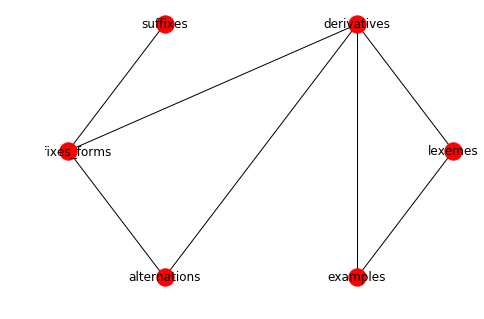

In [123]:
nx.draw_shell(graph, with_labels=True)

In [73]:
joins_complex = {
    tuple(sorted(['lexemes','alternations'])):[('alternations','derivatives'),('lexemes', 'derivatives')],
    tuple(sorted(['lexemes','suffixes_forms'])):[('derivatives','suffixes_forms'),('lexemes','derivatives')],
    tuple(sorted(['lexemes','suffixes'])):[('suffixes_forms', 'suffixes'), ('derivatives', 'suffixes_forms'),('lexemes','derivatives')],
    tuple(sorted(['derivatives','suffixes'])):[('suffixes_forms','suffixes'),('derivatives', 'suffixes_form')],
    tuple(sorted(['alternations','examples'])):[('derivatives','examples'),('alternations','derivatives')],
    tuple(sorted(['alternations','suffixes'])):[('suffixes_forms','suffixes'),('alternations','suffixes_forms')],
    tuple(sorted(['suffixes_forms','examples'])):[('derivatives','examples'),('suffixes_forms','derivatives')],
    tuple(sorted(['','',''])):[('',''),('','')],
}

In [66]:
show_dict.keys()

dict_keys(['lexemes', 'derivatives', 'suffixes', 'suffixes_forms', 'alternations', 'examples'])

In [67]:
filter_dict.keys()

dict_keys(['lexemes', 'suffixes_forms', 'alternations'])

In [138]:
def find_path(tables, graph):
    paths = []
    for x in itertools.combinations(tables,2):
        for path in nx.all_simple_paths(graph, *x):
            if all(table in path for table in tables):
                paths.append(path)
    return sorted(paths, key=lambda x: len(x))[0]

In [147]:
graph.edges[path[0],path[1]]['using']

'id_suffix'

In [187]:
def put_inside_join(path, graph, i=0):
    string = ''
    padding = '\t'*i
    if i+1 < len(path)-1:
        string = f'\n{padding}({path[i]} INNER JOIN ({put_inside_join(path, graph, i+1)})\n{padding}USING({graph.edges[path[i],path[i+1]]["using"]}))'
    else:
        string = f'\n{padding}({path[i]} INNER JOIN ({path[i+1]})\n{padding}USING({graph.edges[path[i],path[i+1]]["using"]}))'
    return string

In [188]:
path

['alternations', 'suffixes_forms', 'derivatives', 'examples', 'lexemes']

In [189]:
print(put_inside_join(path, graph))


(alternations INNER JOIN (
	(suffixes_forms INNER JOIN (
		(derivatives INNER JOIN (
			(examples INNER JOIN (lexemes)
			USING(id_lexeme)))
		USING(id_lexeme)))
	USING(id_suffix_form)))
USING(id_suffix))


In [190]:
tables = set(list(filter_dict.keys()) + list(show_dict.keys()))
path = find_path(tables,graph)
put_inside_join(path, graph)

'\n(suffixes INNER JOIN (\n\t(suffixes_forms INNER JOIN (\n\t\t(alternations INNER JOIN (\n\t\t\t(derivatives INNER JOIN (\n\t\t\t\t(lexemes INNER JOIN (examples)\n\t\t\t\tUSING(id_lexeme)))\n\t\t\tUSING(id_lexeme)))\n\t\tUSING(id_deriv)))\n\tUSING(id_suffix)))\nUSING(id_suffix))'

In [197]:
conditions = []
selects = []
limit=50
for table, columns in filter_dict.items():
    for column, values in columns.items():
        if column in text_columns:
            if 'regex' in values:
                regex = values['regex']
                if regex == 'b':
                    conds = [f'({table}.`{column}` LIKE "{value}%")' for value in values['values']]
                elif regex == 'e':
                    conds = [f'({table}.`{column}` LIKE "%{value}")' for value in values['values']]
                elif regex == 'i':
                    conds = [f'({table}.`{column}` LIKE "%{value}%")' for value in values['values']]
            else:
                conds = [f'({table}.`{column}` LIKE "%{value}%")' for value in values['values']]
        elif column in values_columns:
            if 'is' in column:
                conds = [f'({table}.`{column}` = {value})' for value in values['values']]
            else:
                conds = []
                for value in values['values']:
                    if value == '0':
                        cond = f'({table}.`{column}` is NULL)'
                    else:
                        cond = f'({table}.`{column}` = "{value}")'
                    conds.append(cond)
        elif column in indexes_columns:
            conds = [f'({table}.`{column}` = "{indexes_columns[column][value]}")' for value in values['values']]
        conditions.extend(conds)
    select = ', '.join([f'{table}.`{column}`' for column in show_dict[table]])
    selects.append(select)
selects = ', '.join(selects)
conditions = '\n AND '.join(conditions)

tables = set(list(filter_dict.keys()) + list(show_dict.keys()))
path = find_path(tables,graph)
joins = put_inside_join(path, graph)

req = f"""
SELECT {selects} FROM {joins}
WHERE {conditions}
LIMIT {limit};
"""
print(req)


SELECT lexemes.`cyrillic`, lexemes.`transcription`, lexemes.`definition`, lexemes.`form_cyrillic`, lexemes.`form_transcription`, lexemes.`pos`, lexemes.`cn`, lexemes.`grammar`, lexemes.`type`, lexemes.`type_alternation`, suffixes_forms.`length`, suffixes_forms.`palatalization`, suffixes_forms.`voicing`, alternations.`from`, alternations.`to`, alternations.`isVowel` FROM 
(suffixes INNER JOIN (
	(suffixes_forms INNER JOIN (
		(alternations INNER JOIN (
			(derivatives INNER JOIN (
				(lexemes INNER JOIN (examples)
				USING(id_lexeme)))
			USING(id_lexeme)))
		USING(id_deriv)))
	USING(id_suffix)))
USING(id_suffix))
WHERE (lexemes.`pos` = "2")
 AND (lexemes.`pos` = "A")
 AND (lexemes.`pos` = "2")
 AND (lexemes.`pos` = "A")
 AND (lexemes.`type` is NULL)
 AND (lexemes.`type` = "1")
 AND (lexemes.`type_alternation` is NULL)
 AND (lexemes.`type_alternation` = "1*")
 AND (suffixes_forms.`length` is NULL)
 AND (suffixes_forms.`length` = "1")
 AND (suffixes_forms.`palatalization` = "1")
 AND 

In [198]:
def search(filter_dict, show_dict, limit):
    conditions = []
    selects = []
    for table, columns in filter_dict.items():
        for column, values in columns.items():
            if column in text_columns:
                if 'regex' in values:
                    regex = values['regex']
                    if regex == 'b':
                        conds = [f'({table}.`{column}` LIKE "{value}%")' for value in values['values']]
                    elif regex == 'e':
                        conds = [f'({table}.`{column}` LIKE "%{value}")' for value in values['values']]
                    elif regex == 'i':
                        conds = [f'({table}.`{column}` LIKE "%{value}%")' for value in values['values']]
                else:
                    conds = [f'({table}.`{column}` LIKE "%{value}%")' for value in values['values']]
            elif column in values_columns:
                if 'is' in column:
                    conds = [f'({table}.`{column}` = {value})' for value in values['values']]
                else:
                    conds = []
                    for value in values['values']:
                        if value == '0':
                            cond = f'({table}.`{column}` is NULL)'
                        else:
                            cond = f'({table}.`{column}` = "{value}")'
                        conds.append(cond)
            elif column in indexes_columns:
                conds = [f'({table}.`{column}` = "{indexes_columns[column][value]}")' for value in values['values']]
            conditions.extend(conds)
        select = ', '.join([f'{table}.`{column}`' for column in show_dict[table]])
        selects.append(select)
    selects = ', '.join(selects)
    conditions = '\n AND '.join(conditions)

    tables = set(list(filter_dict.keys()) + list(show_dict.keys()))
    path = find_path(tables,graph)
    joins = put_inside_join(path, graph)

    req = f"""
    SELECT {selects} FROM {joins}
    WHERE {conditions}
    LIMIT {limit};
    """
    print(req)
    cur.execute(req)
    res = cur.fetchall()
    return show_dict[table], res

In [193]:
def search(table, filter_dict, show_dict, limit):
    columns = filter_dict[table]
    conditions = []
    for column, values in columns.items():
        if column in text_columns:
            if 'regex' in values:
                regex = values['regex']
                if regex == 'b':
                    conds = [f'({table}.`{column}` LIKE "{value}%")' for value in values['values']]
                elif regex == 'e':
                    conds = [f'({table}.`{column}` LIKE "%{value}")' for value in values['values']]
                elif regex == 'i':
                    conds = [f'({table}.`{column}` LIKE "%{value}%")' for value in values['values']]
            else:
                conds = [f'({table}.`{column}` LIKE "%{value}%")' for value in values['values']]
        elif column in values_columns:
            if 'is' in column:
                conds = [f'({table}.`{column}` = {value})' for value in values['values']]
            else:
                conds = []
                for value in values['values']:
                    if value == '0':
                        cond = f'({table}.`{column}` is NULL)'
                    else:
                        cond = f'({table}.`{column}` = "{value}")'
                    conds.append(cond)
        elif column in indexes_columns:
            conds = [f'({table}.`{column}` = "{indexes_columns[column][value]}")' for value in values['values']]
        conditions.extend(conds)
        
    selects = ', '.join([f'`{column}`' for column in show_dict[table]])
    conditions = '\n AND '.join(conditions)

    req = f"""
    SELECT {selects} FROM kuruch.{table}
    WHERE {conditions}
    LIMIT {limit};
    """
    print(req)
    cur.execute(req)
    res = cur.fetchall()
    return show_dict[table], res

In [64]:
search('lexemes', filter_dict, show_dict, 50)


    SELECT `cyrillic`, `transcription`, `definition`, `form_cyrillic`, `form_transcription`, `pos`, `cn`, `grammar`, `type`, `type_alternation` FROM kuruch.lexemes
    WHERE (lexemes.`pos` = "2")
 AND (lexemes.`pos` = "A")
 AND (lexemes.`pos` = "2")
 AND (lexemes.`pos` = "A")
 AND (lexemes.`type` is NULL)
 AND (lexemes.`type` = "1")
 AND (lexemes.`type_alternation` is NULL)
 AND (lexemes.`type_alternation` = "1*")
    LIMIT 50;
    


NameError: name 'cur' is not defined

filter_dict, show_dict - {table: column}

In [19]:
filter_dict

NameError: name 'filter_dict' is not defined